### Autoencoder with Convolutional Neural Network
This notebook contains the implementation of an autoencoder for augmentation of the histopathology dataset. The augmented data is used to train CNN networks to see if the accuracy and AUC are higher compared to the baseline CNN model trained on the normal dataset. First, the required libraries are imported and the size of the images in the PCAM dataset is defined.

In [30]:
# Load the functions and classes from main_util.py
from main_util import get_pcam_generators
from main_util import Model_architecture
from main_util import Model_transform

# Standard libraries
import matplotlib.pyplot as plt
%matplotlib inline
import os

# Modelcheckpoint and tensorboard callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.keras.models import load_model

# ROC curve analysis
from sklearn.metrics import roc_curve, auc, RocCurveDisplay


path = 'C:/Users/20212150/Documents/Year 3/Q3/Project AI mia'
# the size of the images in the PCAM dataset
IMAGE_SIZE = 96

### Evaluating baseline CNN model trained on regular data 

First, the model name and the necessary filepaths to save the model are defined in the code block below. 

In [20]:
# Defining model name and paths
model_name = "cnn_baseline"
save_filepath = f"trained_models/{model_name}.tf"
model_filepath = f"trained_models/{model_name}.json"
weights_filepath = f"trained_models/{model_name}_weights.hdf5"

The code block directly below can be used to load the CNN baseline model. This already trained model is trained in the main_manual_training.ipynb file.

In [21]:
# Load weights into the model (ONLY IF MODEL ALREADY EXISTS!!!)
model_cnn = load_model(save_filepath)

# Variables for ROC analysis
train_steps = train_gen.n//train_gen.batch_size
val_steps = val_gen.n//val_gen.batch_size

# Print statement to check if correct model is loaded
print(f"Successfully loaded the following model: {model_name}")

Successfully loaded the following model: cnn_baseline


Now, ROC curve analysis is performed on the baseline CNN model.

  998/10000 [=>............................] - ETA: 3:49WARNING:tensorflow:Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches (in this case, 10000 batches). You may need to use the repeat() function when building your dataset.


10000/10000 [==============================] - 26s 3ms/step


FileNotFoundError: [Errno 2] No such file or directory: '.../project_map/main_project/metric_images/cnn_baseline_auc.png'

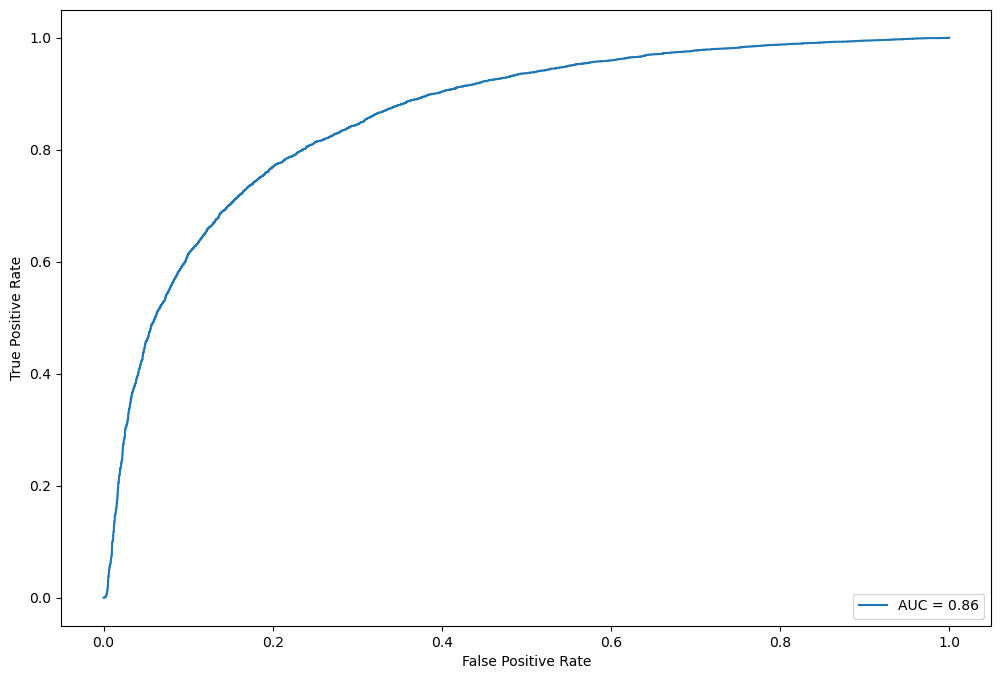

In [24]:
# Getting labels and predictions on validation set
val_true = val_gen.classes
val_probs = model_cnn.predict(val_gen, steps=val_steps*10)

# Calculating false positive rate (fpr), true positive rate (tpr) and AUC
fpr, tpr, thresholds = roc_curve(val_true, val_probs)
roc_auc = auc(fpr, tpr)

# Generate ROC curve
roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
fig, ax1 = plt.subplots(1, 1, figsize=(12, 8))

roc.plot(ax=ax1);
filename_auc = basedir + model_name + '_auc.png'
plt.savefig(filename_auc)

### Training and evaluating the autoencoder model



In [31]:
# Defining model name and paths
model_name = "autoencoder"
save_filepath = f"trained_models/{model_name}.tf"
model_filepath = f"trained_models/{model_name}.json"
weights_filepath = f"trained_models/{model_name}_weights.hdf5"

The code block directly below can be used to load the autoencoder model. This already trained model is trained in the main_manual_training.ipynb file.

In [32]:
# Load weights into the model (ONLY IF MODEL ALREADY EXISTS!!!)
model_ae = load_model(save_filepath)

# Variables for ROC analysis
train_steps = train_gen_ae.n//train_gen_ae.batch_size
val_steps = val_gen_ae.n//val_gen_ae.batch_size

# Print statement to check if correct model is loaded
print(f"Successfully loaded the following model: {model_name}")

Successfully loaded the following model: autoencoder


The output of the autoencoder model is visualized. This output  is used as augmented dataset in the upcoming steps.

1/1 [==============================] - 0s 308ms/step


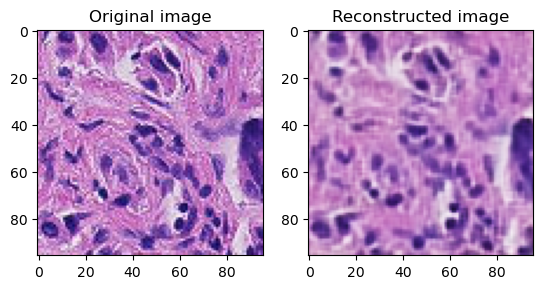

In [35]:
# Produce a prediction on the validation set
img_batch = train_gen_ae[0][1] # [batch][class][image_nr]
predict_test = model_ae.predict(img_batch) 
image_nr = 3

fig,ax = plt.subplots(1,2)
ax[0].imshow(img_batch[image_nr])
ax[0].set_title("Original image")
ax[1].imshow(predict_test[image_nr])
ax[1].set_title("Reconstructed image");

### Training CNN with augmented data using autoencoder



The model name and filepaths for the saved model are defined.

In [26]:
# Defining model name and paths
model_name = "cnn_augmented"
save_filepath = f"trained_models/{model_name}.tf"
model_filepath = f"trained_models/{model_name}.json"
weights_filepath = f"trained_models/{model_name}_weights.hdf5"

The code block directly below can be used to load the CNN with augmented data model. This already trained model is trained in the main_manual_training.ipynb file.

In [29]:
# Load weights into the model (only if model structure & weight already exist!)
AUGMENTATION_FACTOR = 0.75

model_name = "cnn_augmented" + str(AUGMENTATION_FACTOR)
save_filepath = f"trained_models/{model_name}.tf"

cnn_aug_model = load_model(save_filepath)

# Variables for ROC analysis
train_steps = train_gen_aug.n//train_gen_aug.batch_size
val_steps = val_gen_aug.n//val_gen_aug.batch_size

# Print statement to check if correct model is loaded
print(f"Successfully loaded the following model: {model_name}")

cnn_augmented0.75
Successfully loaded the following model: cnn_augmented0.75


1000/1000 [==============================] - 979s 979ms/step


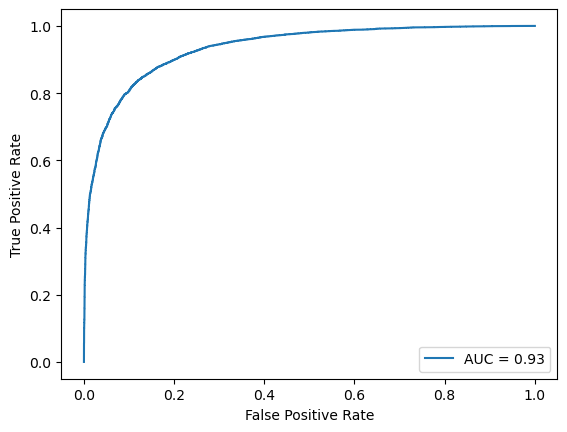

In [18]:
# Getting labels and predictions on validation set
val_true = val_gen_aug.classes
val_probs = model_cnn_aug.predict(val_gen_aug, steps=val_steps*10)

# Calculating false positive rate (fpr), true positive rate (tpr) and AUC
fpr, tpr, thresholds = roc_curve(val_true, val_probs)
roc_auc = auc(fpr, tpr)

# Generate ROC curve
roc = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc.plot()